## Track files comparison for *neuts-6um-2*

### This notebook performs analysis on the different track methods used in cell segmentaiton
### Includes data for artifical tracks
#### Aka tracks that are based on the same mask, making comparison solely on tracking (and not detection) easier


Since our method `name TBD` is the only one method to include interactive, human tracking. We are using our method as a baseline to test the other methods.

*Note, only track data that has been manually corrected is being used as a baseline, data without human interaction is out of scope for this comparison*

In [1]:
# Imports:

import pandas as pd
import glob
from matplotlib import image as img
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path
from PIL import Image
import numpy as np
import scipy
import cv2

In [2]:
# Configurations

%matplotlib inline
sns.set_theme()

from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

### List of abreviations & jargon:


| Abbreviation | Name |
|---|---|
| IH_* | In house |
| TM_* | Trackmate |
| CP_* | Cell Profiler |
| \*_ARTIF_\* | Artificial |

In [3]:
# Fixed parameters
WORKDIR = Path.cwd()
WORKDIR = Path(WORKDIR / '..' )
CUR_PROJECT = 'neuts-6um-2'
TRACK_VERSION = 'v2.1'
INCLUDE_ARTIFICIAL = True

print(f'>\tWorking directory:\t\t{WORKDIR}')
print(f'>\tWorking with dataproject:\t{CUR_PROJECT}')
print(f'>\tTrack version:\t\t\t{TRACK_VERSION}')



>	Working directory:		C:\Users\shane\Documents\Minor_internship_data\viterbi-code\testing\..
>	Working with dataproject:	neuts-6um-2
>	Track version:			v2.1


In [4]:
# User defined modes

SAFE_FILE = False
COMPARE_ALL = True
VERBOSE = False

if COMPARE_ALL:
    print('>\tCompare all mode has been selected.')
else:
    SOFTWARE_LIST = ['in-house', 'Trackmate', 'CellProfiler']
    SOFTWARE = SOFTWARE_LIST[0,1]
    
    print(f'>\tCompare all mode has beed disabled.\nSelected software to be compared:\t{SOFTWARE}')

if INCLUDE_ARTIFICIAL:
    print('>\tIncluding artificial generated tracks has been enabled.')
    

>	Compare all mode has been selected.
>	Including artificial generated tracks has been enabled.


### Functions

In [5]:
def correct_naming_integer(x):
    """
    Makes sure the correct number is given to the filename, making sure sorting isn't messed up.
    """
    x = str(x)
    if len(x) > 3:
        exit('Amount of files is higher than 999')
    if len(x) == 3:
        return x
    if len(x) == 2:
        return '0'+x
    if len(x) == 1:
        return '00'+x

In [6]:
def rand_jitter(arr):
    stdev = arr.max()/100.
    return arr + np.random.randn(len(arr)) * stdev

### Reading data

In [7]:
# read csv with track positions.
# if COMPARE_ALL:
GT_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION /  'NED_tracks.csv'))
IH_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION /  'NED_NHI_tracks.csv'))

#     TM_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION / 'TM_tracks.csv'))
#     CP_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION / 'CP_tracks.csv'))
    
    # Exceptional tracks: 
#   TM_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'TM_LAP_testing.csv'))
#   TM_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'TM_manual_tracks.csv'))

if INCLUDE_ARTIFICIAL:
    TM_ARTIF_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION / 'TM_ARTIF_cleaned_tracks.csv')) 
    CP_ARTIF_df = pd.read_csv(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'tracks' / TRACK_VERSION / 'CP_ARTIF_cleaned_tracks.csv'))
    
TM_df = TM_ARTIF_df
CP_df = CP_ARTIF_df

In [8]:
# In house
if VERBOSE:
    display(IH_df.head())
    display(IH_df.describe())
else:
    print('>\tVerbose mode disabled, re-enable to show output.')

>	Verbose mode disabled, re-enable to show output.


### Basic checks:

#### Checklist:
- ~~Check if the amount of frames is equal~~
- ~~Check the positional data distribution (histogram)~~ 
- Visual check -> ~~plot all the datapoints (like the artificial) movie (Maybe plit these over eachother??)
   Maybe to this for every 10th (or 50th idk) frame of of the movie, to be able to do a quick, visual check of some sorts.~~
- Average direction? (Since we are tracking the same cells, the *average* direction should be identical, right?
- **TODO: add more!**

In [9]:
# Check frames

#  Since we use the var multiple times, declare them here
GT_df_tframe = len(set(GT_df['tframe']))
IH_df_tframe = len(set(IH_df['tframe']))
TM_df_tframe = len(set(TM_df['tframe']))
CP_df_tframe = len(set(CP_df['tframe']))

if IH_df_tframe == TM_df_tframe == CP_df_tframe:
    print('>\tAll datasets contain the same amount of frames!')
    print(f'Number of frames:\t{IH_df_tframe}')
else:
    print('>\tNumber of frames between selected datasets is not even!')
    if COMPARE_ALL:
        print(f'Number of frames:\t{IH_df_tframe}')
        print(f'Number of frames:\t{TM_df_tframe}')
        print(f'Number of frames:\t{CP_df_tframe}')
    else:
        print(f'Selected datasets:\t{SOFTWARE}')

>	All datasets contain the same amount of frames!
Number of frames:	271


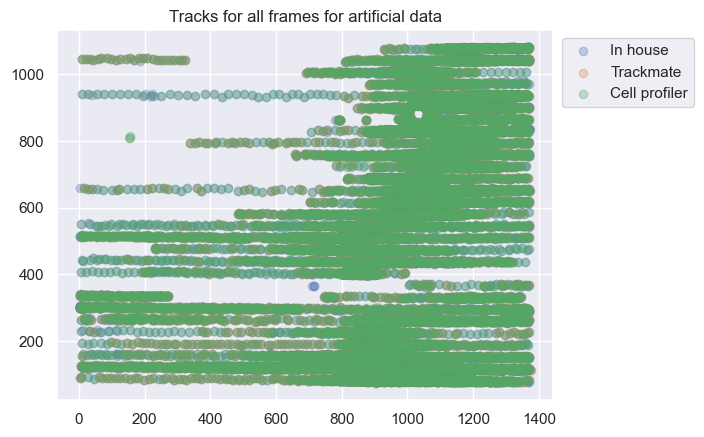

In [10]:
# Check positional data distribution for all datapoints
if INCLUDE_ARTIFICIAL:
    labels = ['Ground-truth', 'In house', 'Trackmate', 'Cell profiler']
    ARTIF_dfs = [IH_df, TM_ARTIF_df, CP_ARTIF_df]

    fig, ax = plt.subplots()
    for i, df in enumerate(ARTIF_dfs):
        x, y = df['x'], df['y']
        ax.scatter(x, y, label=labels[i+1], alpha=0.3)

    ax.legend(loc='upper right', bbox_to_anchor=(1.3,1))
    ax.set_title('Tracks for all frames for artificial data')
    ax.grid(True)
    plt.show()


In [11]:
# Custom legend stuff
from matplotlib.lines import Line2D
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # V2 color codes (gotten from: https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='IH.',
                          markerfacecolor=colors[0], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label='TM.',
                          markerfacecolor=colors[1], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label='CP.',
                          markerfacecolor=colors[2], markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='Comb.',
                          markerfacecolor=colors[3], markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='Frame.',
                          markerfacecolor=colors[4], markersize=12)]

>	Generating plot...


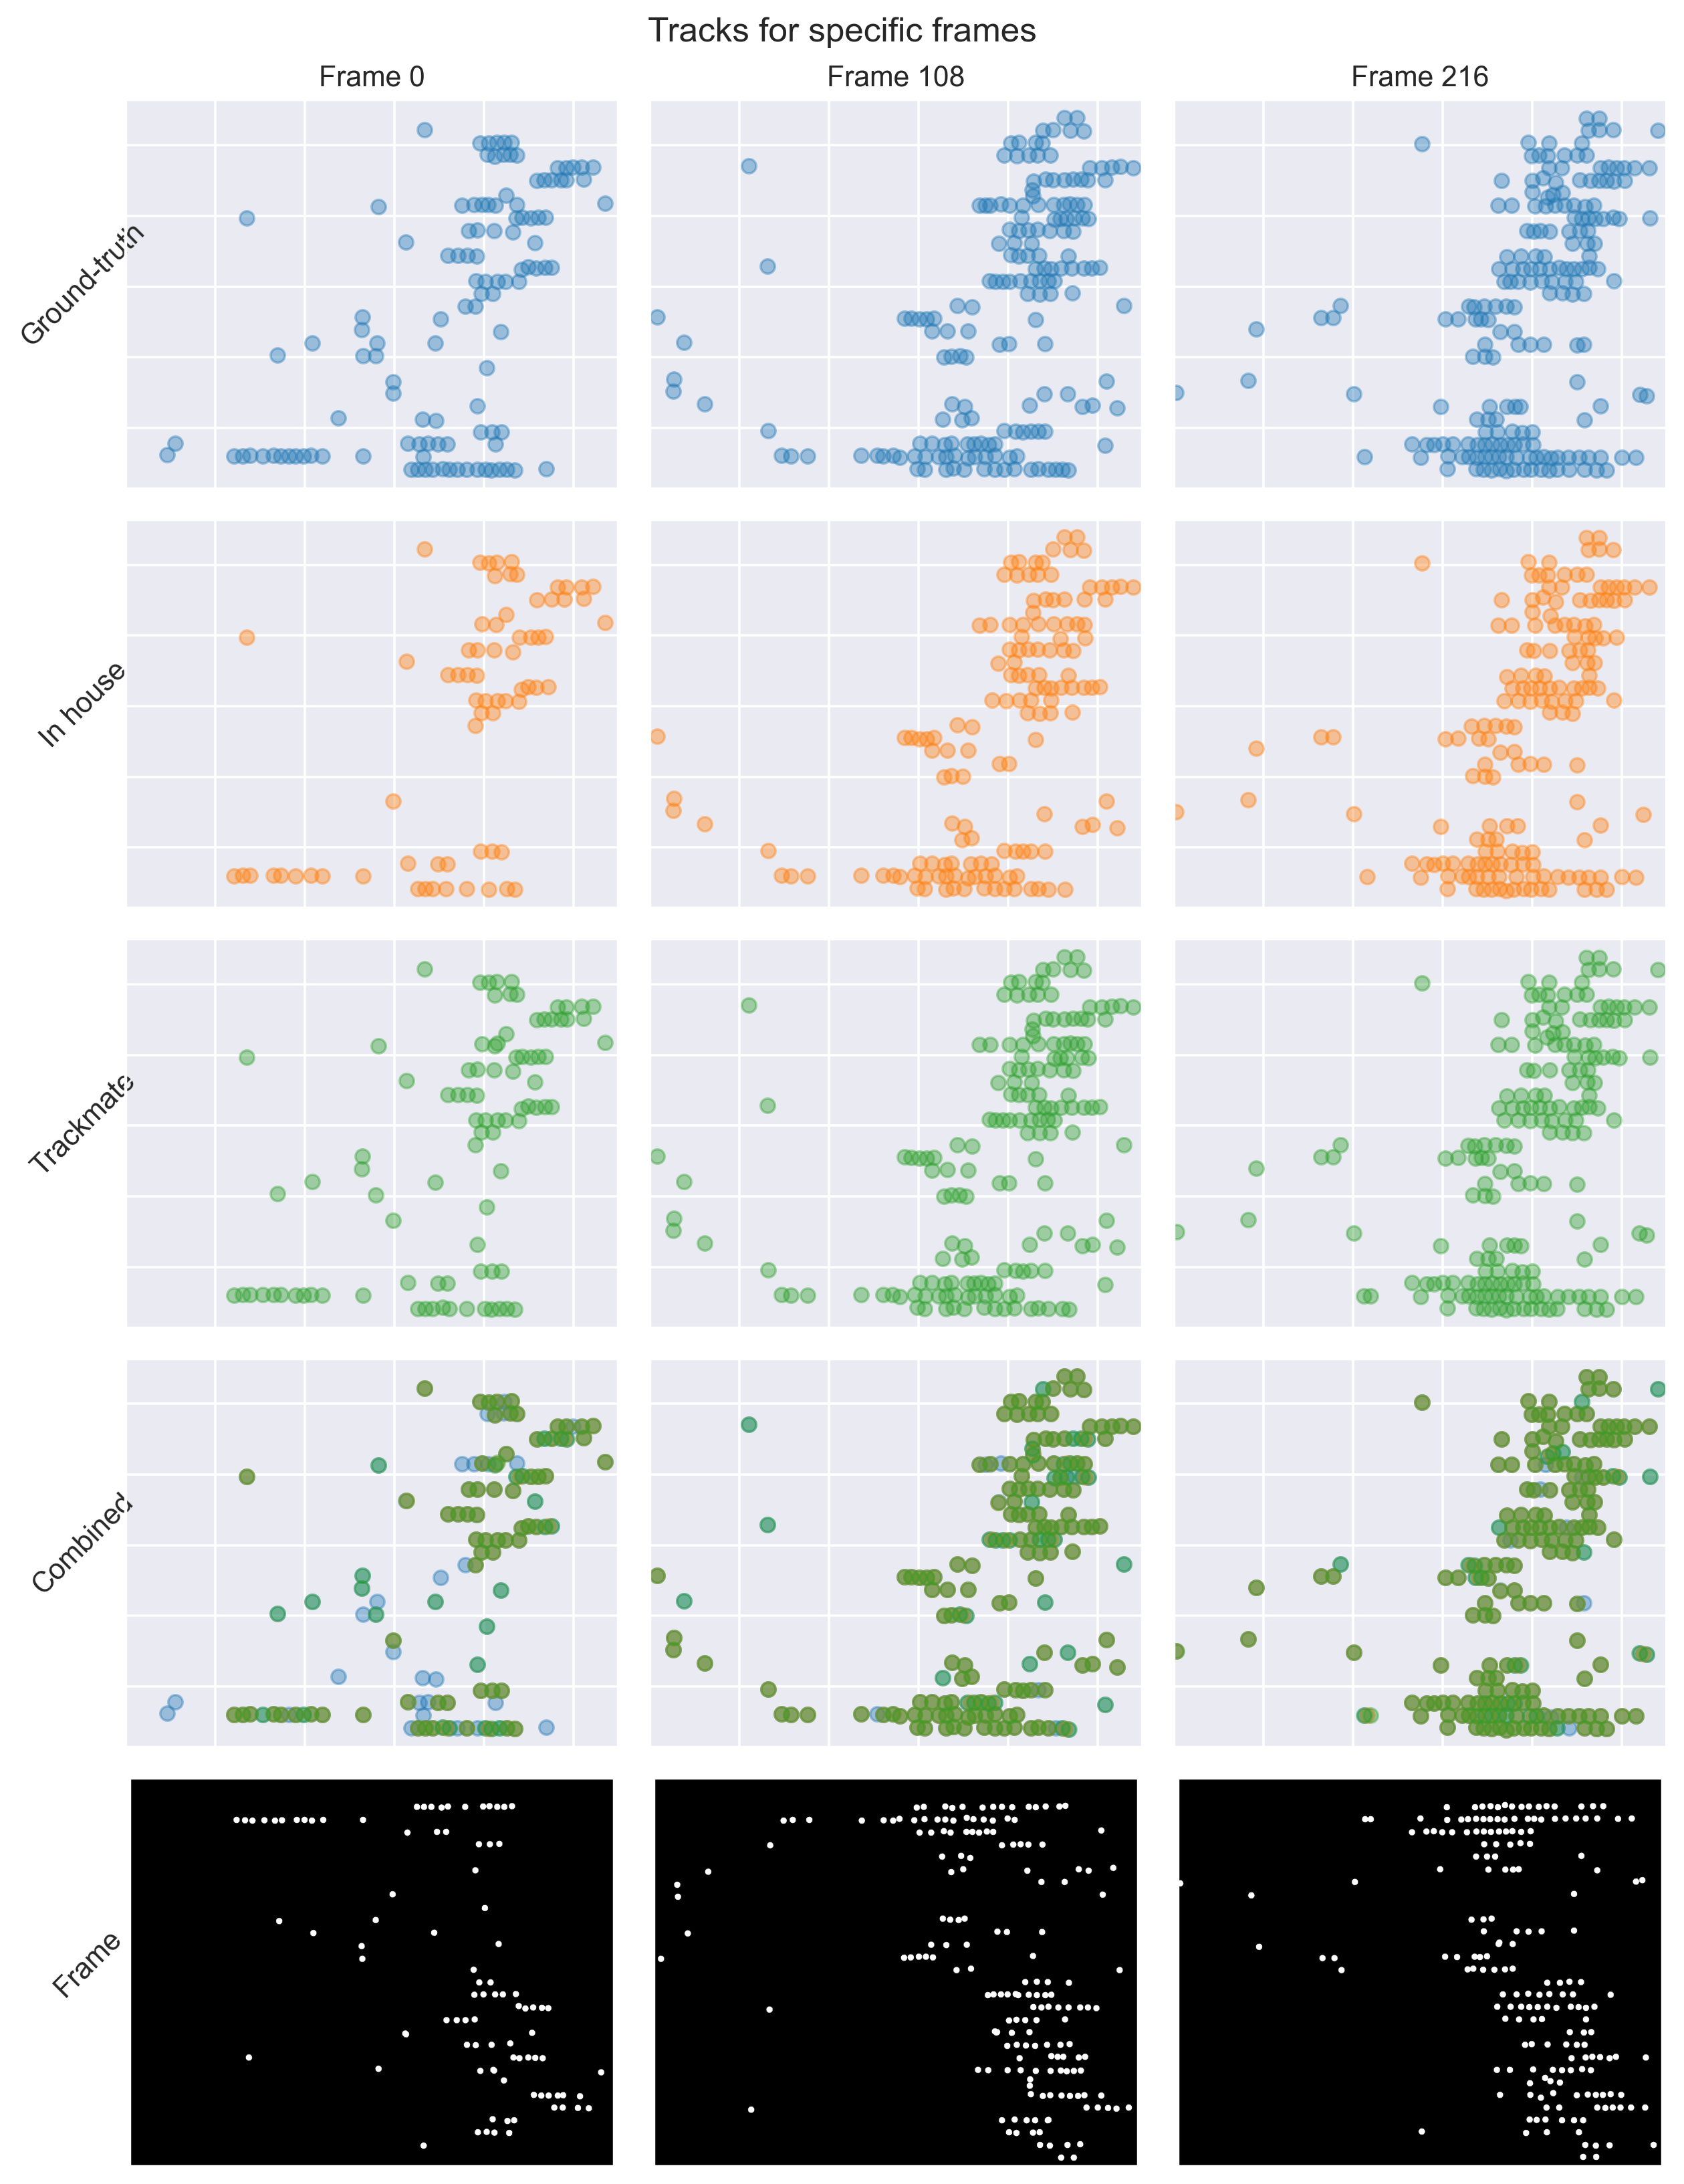

In [12]:
# Check positional data distribution
# pick 3 evenly distributed frames and make the same plots.

if INCLUDE_ARTIFICIAL:
    
    candidate_interval = round(GT_df_tframe / 2.5)
    candidate_frames = np.arange(0, GT_df_tframe, candidate_interval)
    image_list = []

    print('>\tGenerating plot...')

    # To display the images, we need to open them and add them to a list
    for frame in candidate_frames:
        image_list.append(Path(WORKDIR / 'testing' / 'track_projects' / CUR_PROJECT / 'images_ARTIF' /(f'{correct_naming_integer(frame)}.png')))

    rows, cols = 5, 3

    fig, ax = plt.subplots(rows, cols,
                           sharex='col', 
                           sharey='row',
                           figsize=(10, 13),
                           #dpi=80)
                           dpi=256) # Higher dpi is slower, but makes it more clear when zooming

    for row in range(rows):
        for col in range(cols):
            ax[row, col].set_xticklabels([])
            ax[row, col].set_yticklabels([])


            if row <= 2:
                cur_frame = candidate_frames[col]
                df = ARTIF_dfs[row]

                cur_df = df[df['tframe'] == cur_frame]
                x, y = cur_df['x'], cur_df['y']
                ax[row, col].scatter(x, y, label=labels[row], color=colors[row], alpha=0.4)

                ax[3, col].scatter(x, y, label=labels[row], color=colors[row], alpha=0.4) # fill the combined row
                #ax[row, col].set_title(f'{labels[row]}')
                if row == 0:
                    ax[row, col].set_title(f'Frame {cur_frame}')
                if col == 0:    
                    ax[row, col].set_ylabel(f'{labels[row]}', rotation=45, fontdict={'fontsize': 12, 'fontweight': 'medium'})

            elif row == 4:                            
                ax[row, col].imshow(plt.imread(image_list[col]))
                #ax[row,col].imshow(scipy.ndimage.rotate(plt.imread(image_list[col]), 90)) # NOTE: THIS ROTATION SHOULD BE TEMPORARY
                ax[row, col].grid(False)

    ax[3, 0].set_ylabel('Combined', rotation=45, fontdict={'fontsize': 12, 'fontweight': 'medium'}) # Doesn't need to be in the loop
    ax[4, 0].set_ylabel('Frame', rotation=45, fontdict={'fontsize': 12, 'fontweight': 'medium'})

    # Not sure why, but rotation=360 overwrites thight_layout()

    #fig.legend(handles=legend_elements, ncol=5,
    #           loc='upper center', bbox_to_anchor=(0.55,0.93))
    #fig.supxlabel('X coordinates')
    #fig.supylabel('Y coordinates')
    plt.suptitle('Tracks for specific frames')

    fig.tight_layout()
    plt.show()

In [13]:
#print(max(CP_ARTIF_df_plot.shape))
#display(CP_ARTIF_df_plot[CP_ARTIF_df_plot['track_len'] > 2])

>	Generating plots...


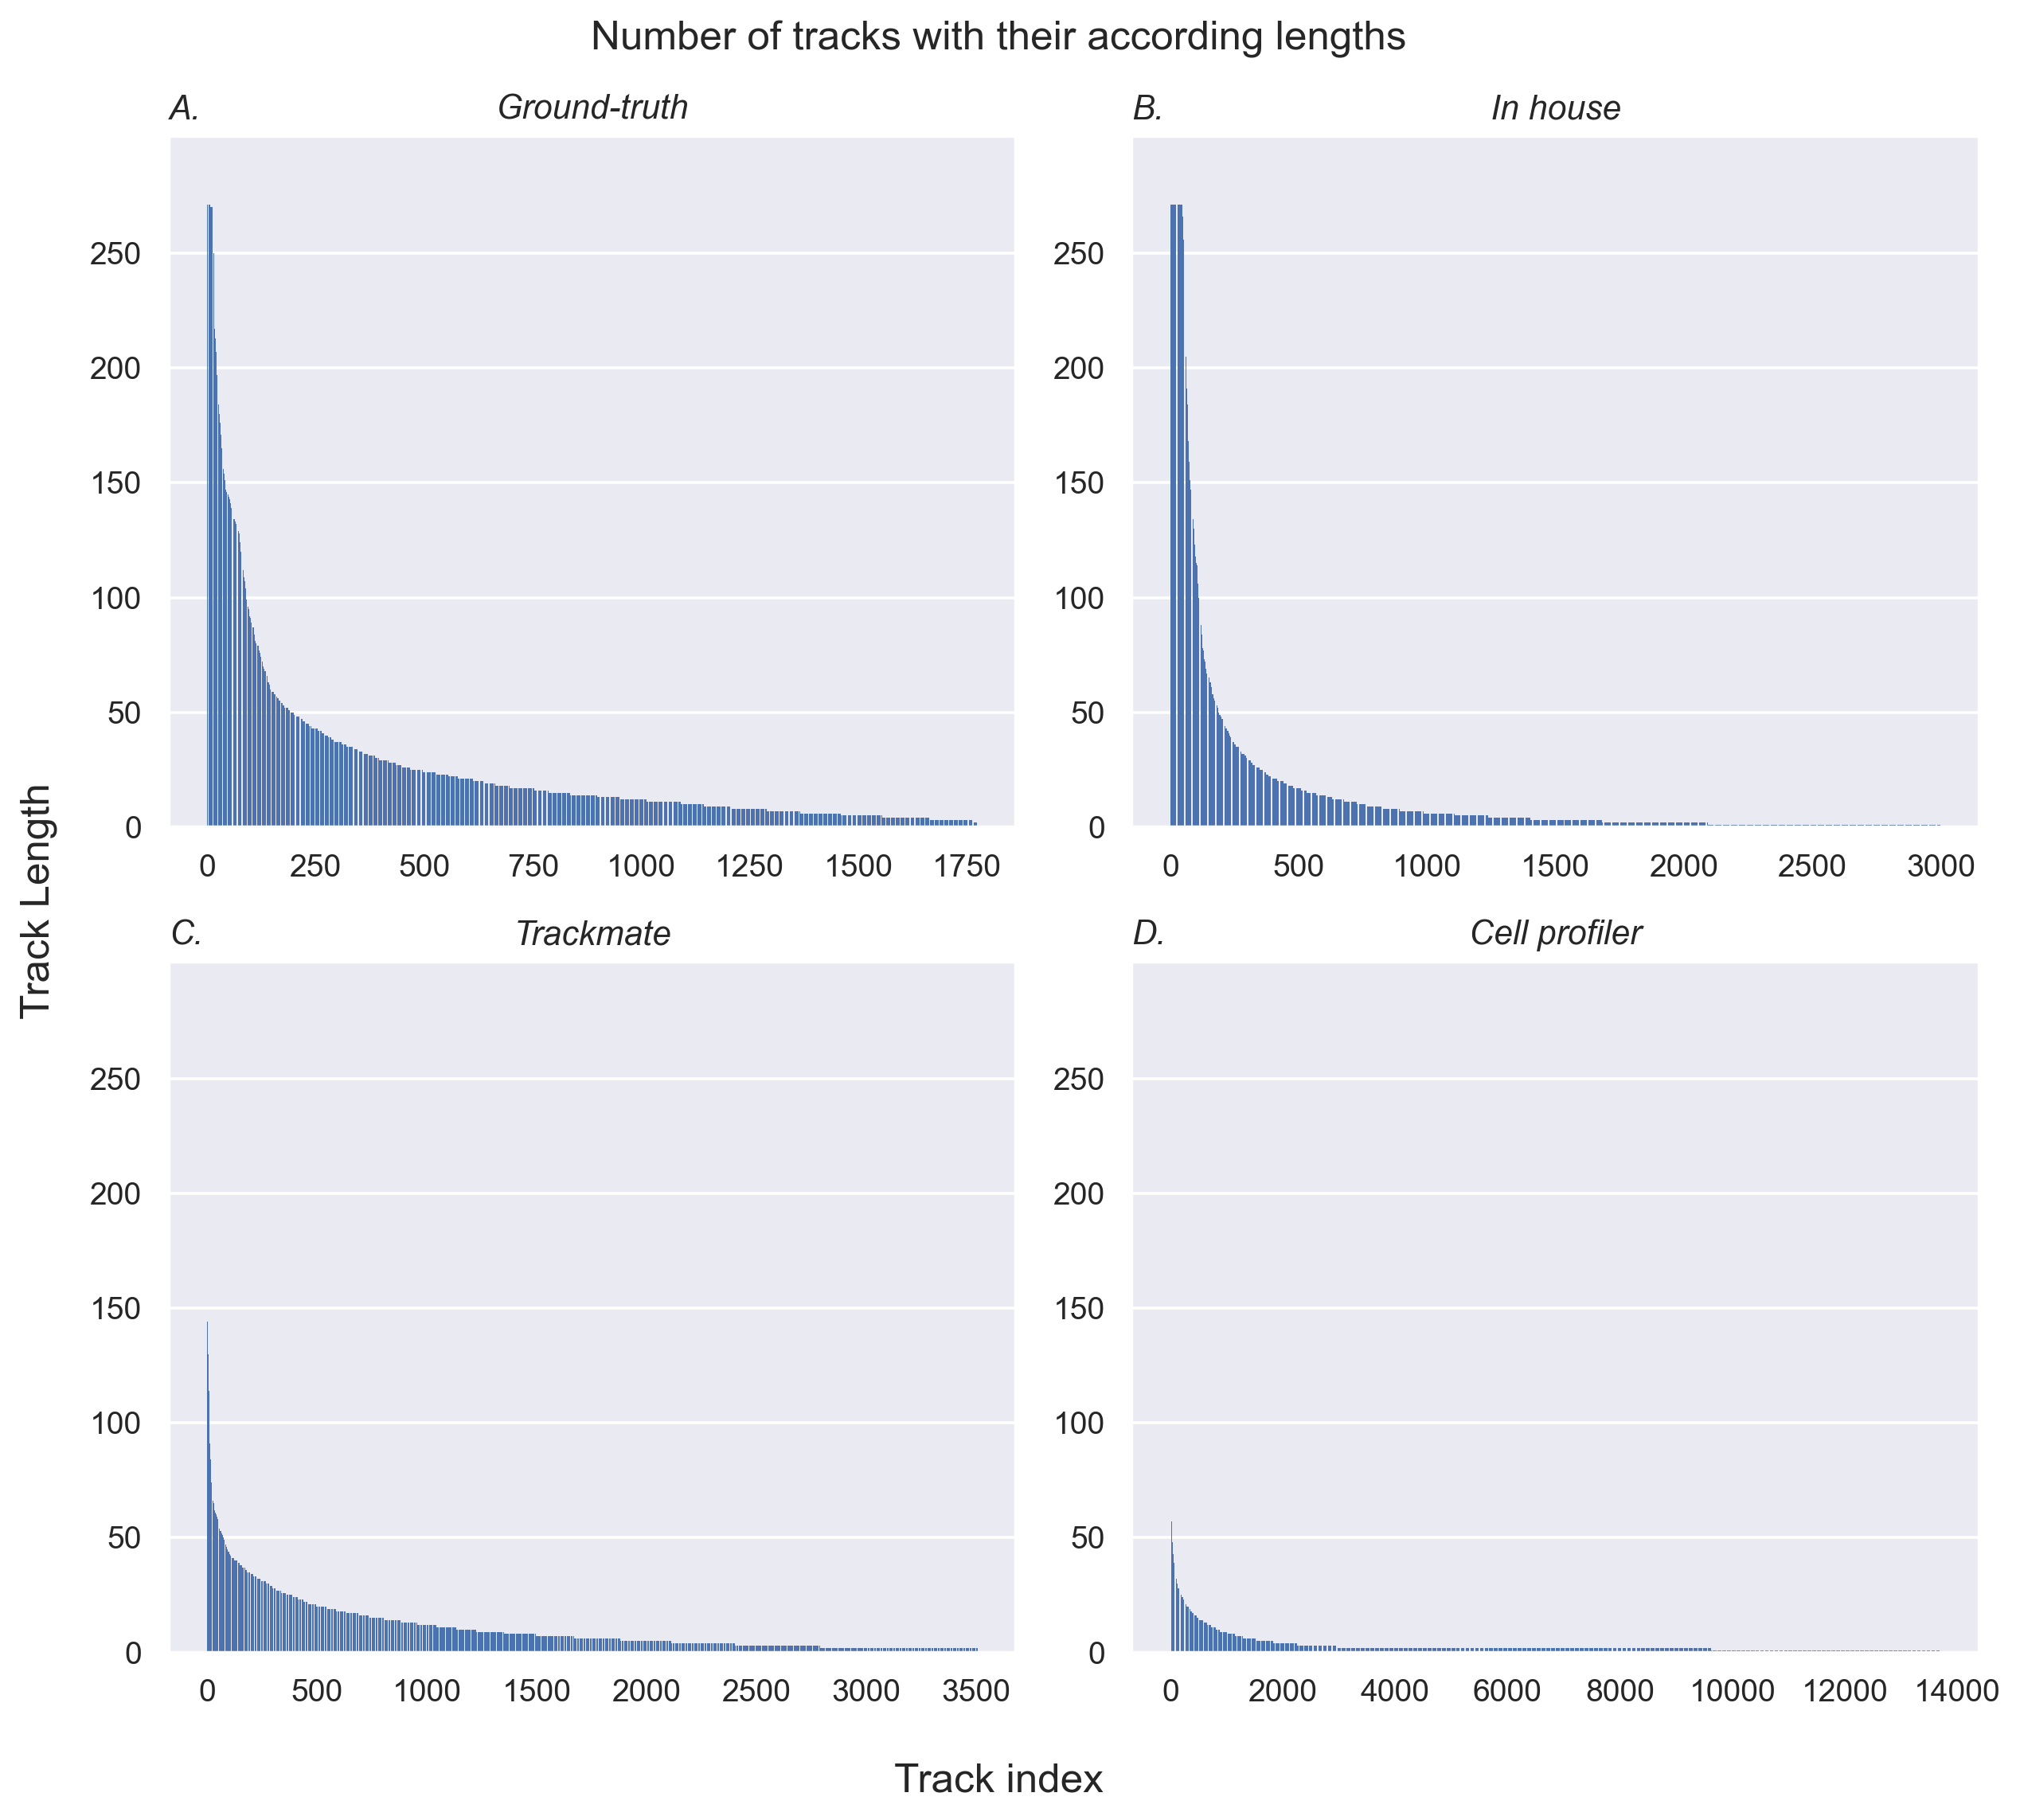

In [36]:
%matplotlib inline
sns.set_theme()
# Check distribution of track lengths
if INCLUDE_ARTIFICIAL:
    print('>\tGenerating plots...')
    
    GT_df['track_len'] = GT_df.groupby(['track'])['track'].transform('count')
    GT_df_plot = GT_df.groupby('track').nth(0)
    GT_df_plot = GT_df_plot.sort_values('track_len', ascending=False).reset_index(drop=True)
#     GT_df_plot = GT_df_plot[GT_df_plot['track_len'] > 5]
    
    IH_df['track_len'] = IH_df.groupby(['track'])['track'].transform('count')
    IH_df_plot = IH_df.groupby('track').nth(0)
    IH_df_plot = IH_df_plot.sort_values('track_len', ascending=False).reset_index(drop=True)
#     IH_df_plot = IH_df_plot[IH_df_plot['track_len'] > 5]
    
#     display(IH_df_plot)

    TM_ARTIF_df['track_len'] = TM_ARTIF_df.groupby(['track'])['track'].transform('count')
    TM_ARTIF_df_plot = TM_ARTIF_df.groupby('track').nth(0)
    TM_ARTIF_df_plot = TM_ARTIF_df_plot.sort_values('track_len', ascending=False).reset_index(drop=True)
#     TM_ARTIF_df_plot = TM_ARTIF_df_plot[TM_ARTIF_df_plot['track_len'] > 5]
    
    CP_ARTIF_df['track_len'] = CP_ARTIF_df.groupby(['track'])['track'].transform('count')
    CP_ARTIF_df_plot = CP_ARTIF_df.groupby('track').nth(0)
    CP_ARTIF_df_plot = CP_ARTIF_df_plot.sort_values('track_len', ascending=False).reset_index(drop=True)
#     CP_ARTIF_df_plot = CP_ARTIF_df_plot[CP_ARTIF_df_plot['track_len'] > 5]

    #pd.set_option("display.max_rows", 20, "display.max_columns", 20)
    # display(IH_df)

#     print('='*80)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 
                                                 2, 
                                                 figsize=(10, 9),
                                                #dpi=80)
                                                 dpi=256)
    fig.suptitle('Number of tracks with their according lengths')
#     fig.suptitle('Number of artificial tracks with their according lengths')

    ax1.bar(GT_df_plot.index, GT_df_plot['track_len'], linewidth = 0)
    ax1.set_ylim([0, int(GT_df_tframe)+30])
    ax1.set_yticks(np.arange(0, int(GT_df_tframe), step=50))
    ax1.set_title('A.', style='italic', loc='left')
    ax1.set_title(labels[0], style='italic', loc='center')
#     ax1.set_xticks(np.arange(0, max(GT_df_plot.index), step=100))
    ax1.grid(axis='x')
    
    ax2.bar(IH_df_plot.index, IH_df_plot['track_len'], linewidth = 0)
    ax2.set_ylim([0, int(IH_df_tframe)+30])
    ax2.set_yticks(np.arange(0, int(IH_df_tframe), step=50))
#     ax2.set_xticks(np.arange(0, max(IH_df_plot.index), step=200))
    ax2.set_title('B.', style='italic', loc='left')
    ax2.set_title(labels[1], style='italic', loc='center')
    ax2.grid(axis='x')


    ax3.bar(TM_ARTIF_df_plot.index, TM_ARTIF_df_plot['track_len'], linewidth = 0)
    ax3.set_ylim([0, int(GT_df_tframe)+30])
    ax3.set_yticks(np.arange(0, int(GT_df_tframe), step=50))
    ax3.set_title('C.', style='italic', loc='left')
    ax3.set_title(labels[2], style='italic', loc='center')
#     ax3.set_xticks(np.arange(0, max(TM_ARTIF_df_plot.index), step=100))
    ax3.grid(axis='x')
    

    ax4.bar(CP_ARTIF_df_plot.index, CP_ARTIF_df_plot['track_len'], linewidth = 0)
    ax4.set_ylim([0, int(GT_df_tframe)+30])
    ax4.set_yticks(np.arange(0, int(GT_df_tframe), step=50))
#     ax4.set_xticks(np.arange(0, max(CP_ARTIF_df_plot.index), step=100))
    ax4.set_title('D.', style='italic', loc='left')
    ax4.set_title(labels[3], style='italic', loc='center')
    ax4.grid(axis='x')
    
    fig.supxlabel('Track index')
    fig.supylabel('Track Length')
    fig.tight_layout()

    #plt.show()
    #for ax in fig.get_axes():
    #    ax.label_outer()

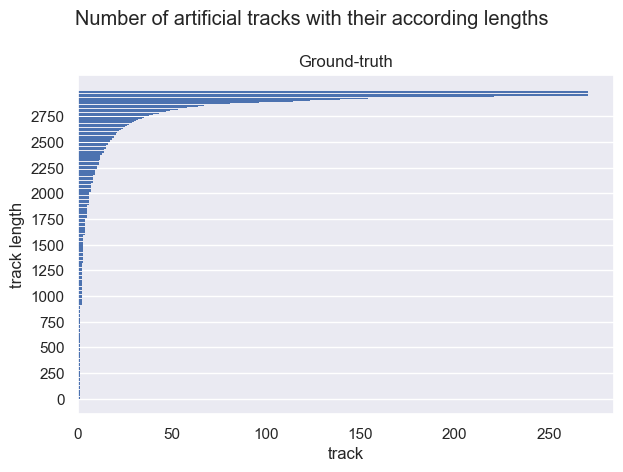

In [15]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Number of artificial tracks with their according lengths')

ax1.barh(IH_df_plot.index, IH_df_plot['track_len'].sort_values(), linewidth = 0)
# ax1.set_ylim([0, int(IH_df_tframe)+30])
ax1.set_xticks(np.arange(0, int(IH_df_tframe), step=50))
ax1.set_title(labels[0])
ax1.set_yticks(np.arange(0, max(IH_df_plot.index), step=250))
ax1.set_title(labels[0])
ax1.set_xlabel('track')
ax1.set_ylabel('track length')
ax1.grid(axis='x')
    
fig.tight_layout()


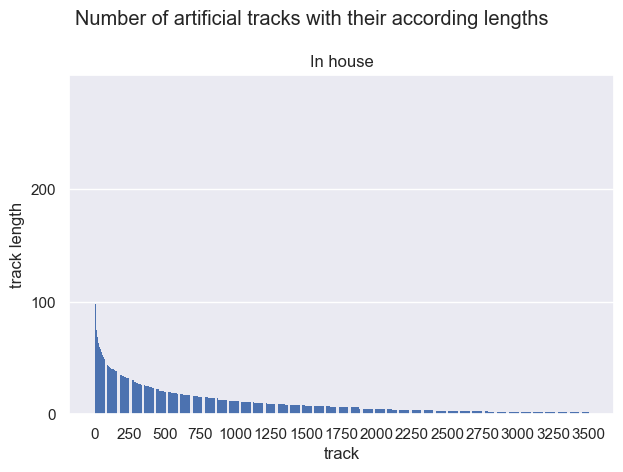

In [16]:
fig, (ax2) = plt.subplots(1, 1)
fig.suptitle('Number of artificial tracks with their according lengths')

ax2.bar(TM_ARTIF_df_plot.index, TM_ARTIF_df_plot['track_len'], linewidth = 0)
ax2.set_ylim([0, int(IH_df_tframe)+30])
ax2.set_yticks(np.arange(0, int(IH_df_tframe), step=100))
ax2.set_title(labels[1])
ax2.set_xticks(np.arange(0, max(TM_ARTIF_df_plot.index), step=250))
ax2.set_xlabel('track')
ax2.set_ylabel('track length')
ax2.grid(axis='x')

fig.tight_layout()

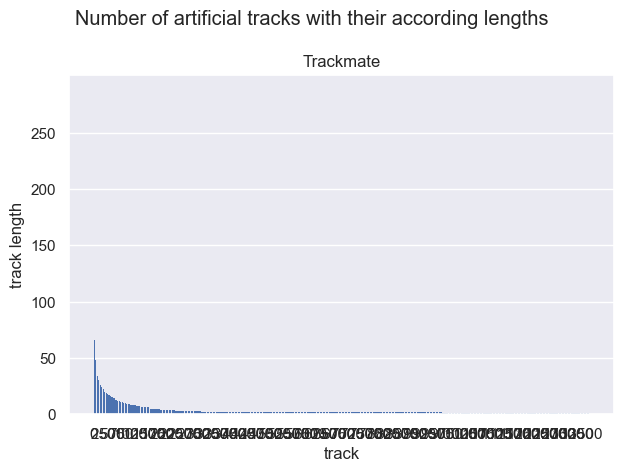

In [17]:
fig, (ax3) = plt.subplots(1, 1)
fig.suptitle('Number of artificial tracks with their according lengths')

ax3.bar(CP_ARTIF_df_plot.index, CP_ARTIF_df_plot['track_len'], linewidth = 0)
ax3.set_ylim([0, int(IH_df_tframe)+30])
ax3.set_yticks(np.arange(0, int(IH_df_tframe), step=50))
ax3.set_xticks(np.arange(0, max(CP_ARTIF_df_plot.index), step=250))
ax3.set_xlabel('track')
ax3.set_ylabel('track length')
ax3.set_title(labels[2])
ax3.grid(axis='x')

fig.tight_layout()

In [18]:
#fig1, ax1 = plt.bar(dfs[1]['x'], 5)

In [19]:
IH_df['track_len']

0         17
1        271
2        271
3         54
4         20
        ... 
46865    271
46866    271
46867     54
46868    220
46869    271
Name: track_len, Length: 46870, dtype: int64

In [20]:
CP_df['track_len']

0        61
1         7
2         8
3        11
4         4
         ..
45389     3
45390     4
45391     4
45392     4
45393     4
Name: track_len, Length: 45394, dtype: int64

### Combining data

In [21]:
# We need to find a way to add them together, since we are not sure about the ID's

# all_df = pd.concat([IH_df, TM_df, CP_df], on='?')